In [1]:
import matplotlib.pyplot as plt
import multiprocessing   as mp
import numpy             as np

from scipy.optimize      import minimize, LinearConstraint

import gym
import gym_Merton
import A2C_III

# Single Asset Merton Model

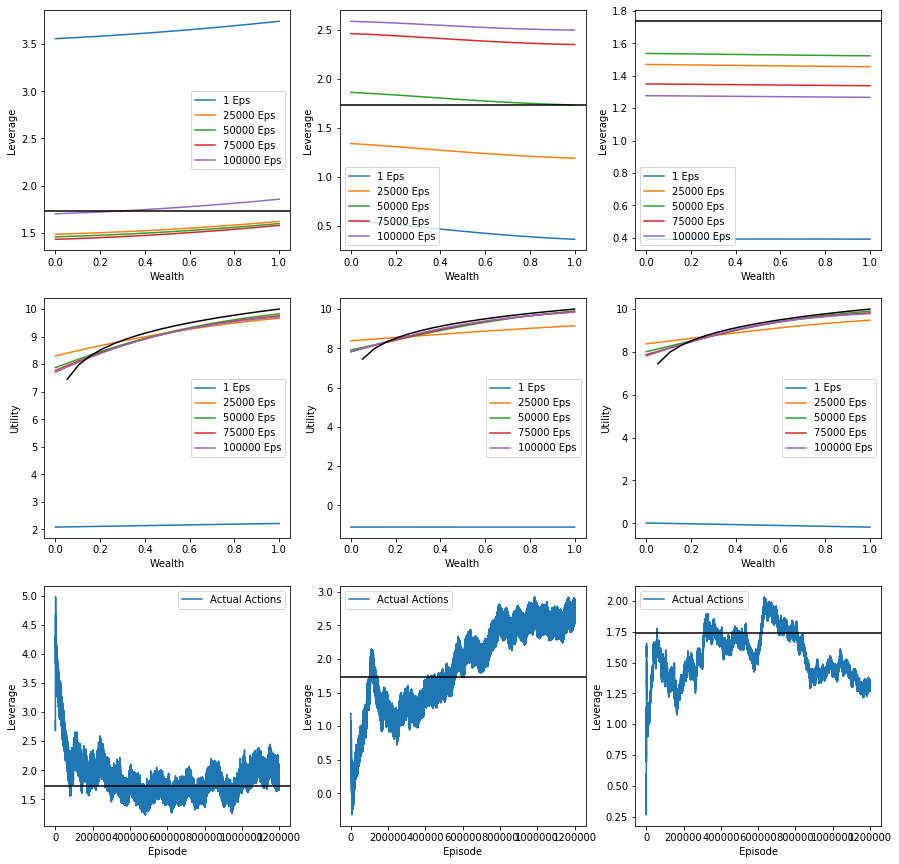

CPU times: user 11.6 s, sys: 1.13 s, total: 12.8 s
Wall time: 3min 53s


In [2]:
%%time

# Model Parameters.
Retrain_Frequency = 10
Sigma_Range       = [2, 0.01]
Sigma_Anneal      = 0.7
Gamma             = 0.99

Mu       = 0.05
Sigma    = 0.16
Row      = 1
Rf       = 0.01
Risk_Adv = 0.9

N_Eps    = int(1e5)

Actor_Hypers   = {"Learning Rate" : 0.075,
                 "Epoch"         : 1,
                 "Network Size"  : [4,4],
                 "Activation"    : "Sigmoid"}

Critic_Hypers = {"Learning Rate" : 0.005,
                 "Epoch"         : 1,
                 "Network Size"  : [4,4],
                 "Activation"    : "Sigmoid"}


# Run the algorithm.
def Run_Model(seed):
    np.random.seed(seed)
    Merton_Env = gym.make('Merton-v0', Mu = Mu, Sigma = Sigma, Row = Row, Rf = Rf,
                           Max_Leverage  = 750,
                           Min_Leverage  = -750,
                           Time_Horizon  = 1,
                           Time_Step     = 1/12,
                           Risk_Aversion = Risk_Adv)

 
    myAC = A2C_III.Actor_Critic(Merton_Env, Actor_Hypers, Critic_Hypers, Gamma, Sigma_Range,
                                Sigma_Anneal, Retrain_Frequency)
    
    return myAC.Train(N_Eps)


pool = mp.Pool(3)
Results = pool.map(Run_Model, (np.random.uniform(size = 3) * 1000).astype(int))
pool.close()


# Plot the results.
f, ax = plt.subplots(3,3, figsize = (15, 15))
for i in range(len(Results)):
    for j in range(len(Results[i][1])):
        ax[0, i].plot(np.linspace(0,1,20), Results[i][1][j]["Policy"], label = Results[i][1][j]["Title"])
        ax[1, i].plot(np.linspace(0,1,20), Results[i][1][j]["Value"], label = Results[i][1][j]["Title"])
    
    ax[0, i].set_xlabel("Wealth")
    ax[0, i].set_ylabel("Leverage")
    ax[0, i].axhline((Mu - Rf) / (Risk_Adv * (Sigma ** 2)), color = 'k')
    ax[0, i].legend()

    ax[1, i].set_xlabel("Wealth")
    ax[1, i].set_ylabel("Utility")
    ax[1, i].legend()

    if Risk_Adv == 1:
        ax[1, i].plot(np.linspace(0,1,20), 
                      [None] + list(np.log(np.linspace(0,1,20)[1::])), 
                      color = 'k')
    else:
        ax[1, i].plot(np.linspace(0,1,20), 
                      [None] + list((np.linspace(0,1,20)[1::] ** (1 - Risk_Adv)) / (1 - Risk_Adv)), 
                      color = 'k')


    ax[2, i].plot(np.array(Results[i][0]).reshape(-1), label = "Actual Actions")
    ax[2, i].set_xlabel("Episode")
    ax[2, i].set_ylabel("Leverage")
    ax[2, i].axhline((Mu - Rf) / (Risk_Adv * (Sigma ** 2)), color = 'k')
    ax[2, i].legend()

plt.show()


# Mulit Asset Merton Model

In [ ]:
def Sharpe_Ratio(Weights):
    Weights = np.array(Weights)
    Excess_ret = np.sum(Weights * Mu) - Rf
    
    Std = Sigma.reshape(-1,1)
    Cov = Row * np.matmul(Std, Std.T)
    
    Weights = Weights.reshape(-1,1)
    Var = np.matmul(np.matmul(Weights.T, Cov), Weights)
    
    Sharpe = Excess_ret / (Var ** 0.5)[0,0]
    
    return -Sharpe

def Merton_Leverage(Weights):
    Weights = np.array(Weights)
    Return = np.sum(Weights * Mu)
    
    Std = Sigma.reshape(-1,1)
    Cov = Row * np.matmul(Std, Std.T)
    
    Weights = Weights.reshape(-1,1)
    Var = np.matmul(np.matmul(Weights.T, Cov), Weights)
    
    return (Return - Rf) / (Risk_Adv * (Var[0,0]))


In [ ]:
%%time

# Model Parameters.
Retrain_Frequency = 10
Sigma_Range       = [2, 0.01]
Sigma_Anneal      = 0.9
Gamma             = 0.99

# Mu       = np.array([0.5, 0.03, 0.07])
# Sigma    = np.array([0.30, 0.15, 0.25])
# Row      = np.array([[1.00, 0.07, -0.09], 
#                      [0.07, 1.00, -0.02],
#                      [-0.09, -0.02, 1.00]])

Mu    = np.array([0.05, 0.03])
Sigma = np.array([0.30, 0.15])
Row   = np.array([[1.00, -0.07], [-0.07, 1.00]])

Rf       = 0.01
Risk_Adv = 0.9

N_Eps    = int(1e5)
N        = len(Mu)

Actor_Hypers   = {"Learning Rate" : 0.075,
                 "Epoch"         : 1,
                 "Network Size"  : [4,4],
                 "Activation"    : "Sigmoid"}

Critic_Hypers = {"Learning Rate" : 0.05,
                 "Epoch"         : 10,
                 "Network Size"  : [4,4],
                 "Activation"    : "Sigmoid"}



# Run the algorithm.
def Run_Model(seed):
    np.random.seed(seed)
    Merton_Env = gym.make('Merton-v0', Mu = Mu, Sigma = Sigma, Row = Row, Rf = Rf,
                           Max_Leverage  = 750,
                           Min_Leverage  = -750,
                           Time_Horizon  = 1,
                           Time_Step     = 1/12,
                           Risk_Aversion = Risk_Adv)

 
    myAC = A2C_III.Actor_Critic(Merton_Env, Actor_Hypers, Critic_Hypers, Gamma, Sigma_Range,
                                Sigma_Anneal, Retrain_Frequency)
    
    return myAC.Train(N_Eps)

pool = mp.Pool(3)
Results = pool.map(Run_Model, (np.random.uniform(size = 3) * 1000).astype(int))
pool.close()



# Before plotting calculate the actual solution
cons = [{'type': 'ineq', 'fun': lambda x:  np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: -np.sum(x) + 1}]

Opt_Weights = minimize(Sharpe_Ratio, [1/N] * N, constraints = cons).x
Opt_leverage = Merton_Leverage(Opt_Weights)
Opt_Weights = Opt_Weights * Opt_leverage


# Plot the results
f, ax = plt.subplots(N+2,3, figsize = (15, 5 * (N+2)))
for i in range(3):
    for j in range(N):
        for k in range(len(Results[i][1])):
            ax[j, i].plot(np.linspace(0,1,20), Results[i][1][k]["Policy"][:,j], label = Results[i][1][k]["Title"])   

        ax[j, i].set_xlabel("Wealth")
        ax[j, i].set_ylabel("Leverage")
        ax[j, i].axhline(Opt_Weights[j], color = 'k')
        ax[j, i].legend()

    for j in range(len(Results[i][1])):
        ax[N, i].plot(np.linspace(0,1,20), Results[i][1][j]["Value"], label = Results[i][1][j]["Title"])
    ax[N, i].set_xlabel("Wealth")
    ax[N, i].set_ylabel("Utility")
    ax[N, i].legend()

    if Risk_Adv == 1:
        ax[N, i].plot(np.linspace(0,1,20), 
                      [None] + list(np.log(np.linspace(0,1,20)[1::])), 
                      color = 'k')
    else:
        ax[N, i].plot(np.linspace(0,1,20), 
                      [None] + list((np.linspace(0,1,20)[1::] ** (1 - Risk_Adv)) / (1 - Risk_Adv)), 
                      color = 'k')


    
    for j in range(Mu.size):
        ax[N+1, i].plot(np.array(Results[i][0])[:,j], label = "Actual Actions")
        ax[N+1, i].axhline(Opt_Weights[j], color = 'k')
    ax[N+1, i].set_xlabel("Episode")
    ax[N+1, i].set_ylabel("Leverage")
    ax[N+1, i].legend()
